In [1]:
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy
import numpy as np
import panopticapi
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms as transforms
from panopticapi.utils import id2rgb, rgb2id
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
seed = 42
torch.manual_seed(seed)

CLASSES = [
    "N/A",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]


In [2]:
%reload_ext autoreload
%autoreload 2

In [2]:
class FullImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        self.files = [x for x in self.root_dir.glob("**/*") if x.is_file()]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        img_path = self.files[idx]

        image = Image.open(img_path).convert("RGB")
        width = image.width
        height = image.height

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image, "path": img_path, "width": width, "height": height}


transform = transforms.Compose(
    [
        transforms.Resize((800, 800)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ],
)


def box_cxcywh_to_square_xyxy(x, width, height):
    x_c, y_c, w, h = x
    h = max(h, w * width / height)
    w = max(w, h * height / width)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.FloatTensor(b)


def rescale_bboxes(out_bbox, width, height):
    b = box_cxcywh_to_square_xyxy(out_bbox, width, height)
    b = b * torch.tensor([width, height, width, height], dtype=torch.float32)
    return b


def collate_batch(batch):
    images = torch.stack([elem["image"] for elem in batch])
    paths = [elem["path"] for elem in batch]
    widths = [elem["width"] for elem in batch]
    heights = [elem["height"] for elem in batch]
    return {"images": images, "paths": paths, "widths": widths, "heights": heights}


bird_index = CLASSES.index("bird")

dataset = FullImageDataset("bird_dataset/train_images", transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_batch,
)


In [ ]:
model = (torch.hub.load("facebookresearch/detr", "detr_resnet50", pretrained=True),)
model.eval()


In [ ]:
with tqdm(dataloader, unit="batch") as vepoch:
    model.eval()
    for batch in vepoch:
        images = batch["images"]
        paths = batch["paths"]
        widths = batch["widths"]
        heights = batch["heights"]

        outputs = model(images)
        for pred_boxes, pred_logits, path, width, height in zip(
            outputs["pred_boxes"], outputs["pred_logits"], paths, widths, heights
        ):
            probas = pred_logits.softmax(-1)[:-1]
            keep = probas[bird_index] > 0.7

            im = Image.open(path).convert("RGB")
            parts = list(path.parts)
            parts[1] += "_cropped"
            cropped_path = Path(*parts)
            cropped_path.parents[0].mkdir(parents=True, exist_ok=True)
            if torch.sum(keep) > 0:
                largest_box_index = np.argmin(
                    [(box[2] * box[3]).item() for box in pred_boxes[keep]]
                )
                bboxes_scaled = rescale_bboxes(
                    pred_boxes[keep][largest_box_index], width, height
                )
                im = im.crop(bboxes_scaled.tolist())
            else:
                print(f"Image at {path} not cropped")
            im.save(cropped_path)


Images with problem on train:

* `004.Groove_billed_Ani/Groove_Billed_Ani_0068_1538.jpg`
* `030.Fish_Crow/Fish_Crow_0024_26064.jpg`
* `028.Brown_Creeper/Brown_Creeper_0111_24590.jpg`

Images with problem on validation:

* `026.Bronzed_Cowbird/Bronzed_Cowbird_0002_796244.jpg`

Image with problem on test:

* `mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg`
* `mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg`
* `mistery_category/15d6c5d42688cbc390e9ba241e93b941.jpg`
* `mistery_category/0ab685b1515b7d4c76691e8373a65f47.jpg`
* `mistery_category/4836bedeec2a2617ee33922ebf89995a.jpg`
* `mistery_category/8367922ad8b74c6047ea82f4d527ce04.jpg`

## Segmentation

In [3]:
model, postprocessor = torch.hub.load(
    "facebookresearch/detr",
    "detr_resnet101_panoptic",
    pretrained=True,
    return_postprocessor=True,
    num_classes=250,
)
model.eval()


Using cache found in /home/matias/.cache/torch/hub/facebookresearch_detr_main
/home/matias/.pyenv/versions/3.9.8/envs/MVA/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matias/.pyenv/versions/3.9.8/envs/MVA/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      

In [5]:
def compute_index_min_max(arr, axis):
    diff_x = np.diff(arr.astype(float), axis=axis)
    diff_x_min = np.argmin(diff_x, axis=axis)
    x_min = np.min(diff_x_min[diff_x_min > 0])

    diff_x_max = np.argmax(diff_x, axis=axis)
    x_max = np.max(diff_x_max[diff_x_max > 0])
    return x_min, x_max


def compute_box_cxcywh(arr, square_width):
    y_min, y_max = compute_index_min_max(arr, axis=0)
    x_min, x_max = compute_index_min_max(arr, axis=1)
    x_c = (x_max + x_min) / 2 / square_width
    y_c = (y_max + y_min) / 2 / square_width
    w = (x_max - x_min) / square_width
    h = (y_max - y_min) / square_width
    return [x_c, y_c, w, h]


def perform_and_save_segmentation(
    results, paths, widths, heights, square_width, pad_value, inference_transform
):
    for result, path, width, height in zip(results, paths, widths, heights):
        segmentation = Image.open(io.BytesIO(result["png_string"]))
        segmentation = np.transpose(np.array(segmentation, dtype=np.uint8), (2, 0, 1))

        im = np.array(inference_transform(Image.open(path).convert("RGB")))
        irrelevant_id = -1
        for segment_info in result["segments_info"]:
            if segment_info["category_id"] != 16:
                irrelevant_id = segment_info["id"]
                mask = segmentation[0, :, :] == irrelevant_id
                im[0:3, mask] = pad_value

        if irrelevant_id != -1:
            bbox = compute_box_cxcywh(
                segmentation[0] == irrelevant_id, square_width
            )
            bbox_scaled = rescale_bboxes(bbox, width, height)
            im = Image.fromarray(np.uint8(np.transpose(im * 255, (1, 2, 0)))).convert(
                "RGB"
            )
            im = transforms.Resize((height, width))(im)
            im = im.crop(bbox_scaled.tolist())

            parts = list(path.parts)
            parts[1] += "_segmented"
            cropped_path = Path(*parts)
            cropped_path.parents[0].mkdir(parents=True, exist_ok=True)
        else:
            im = Image.open(path).convert("RGB")
        im.save(cropped_path)


with tqdm(dataloader, unit="batch") as vepoch:
    model.eval()
    square_width = 800
    pad_value = 1
    inference_transform = transforms.Compose(
        [
            transforms.Resize((square_width, square_width)),
            transforms.ToTensor(),
        ],
    )
    for batch in vepoch:
        images = batch["images"]
        paths = batch["paths"]
        widths = batch["widths"]
        heights = batch["heights"]

        outputs = model(images)
        results = postprocessor(
            outputs, torch.as_tensor(images.shape[-2:]).unsqueeze(0)
        )
        perform_and_save_segmentation(
            results,
            paths,
            widths,
            heights,
            square_width,
            pad_value,
            inference_transform,
        )
    raise Value

  0%|          | 0/1082 [00:00<?, ?batch/s]/home/matias/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
  0%|          | 1/1082 [00:05<1:36:48,  5.37s/batch]

: 

: 

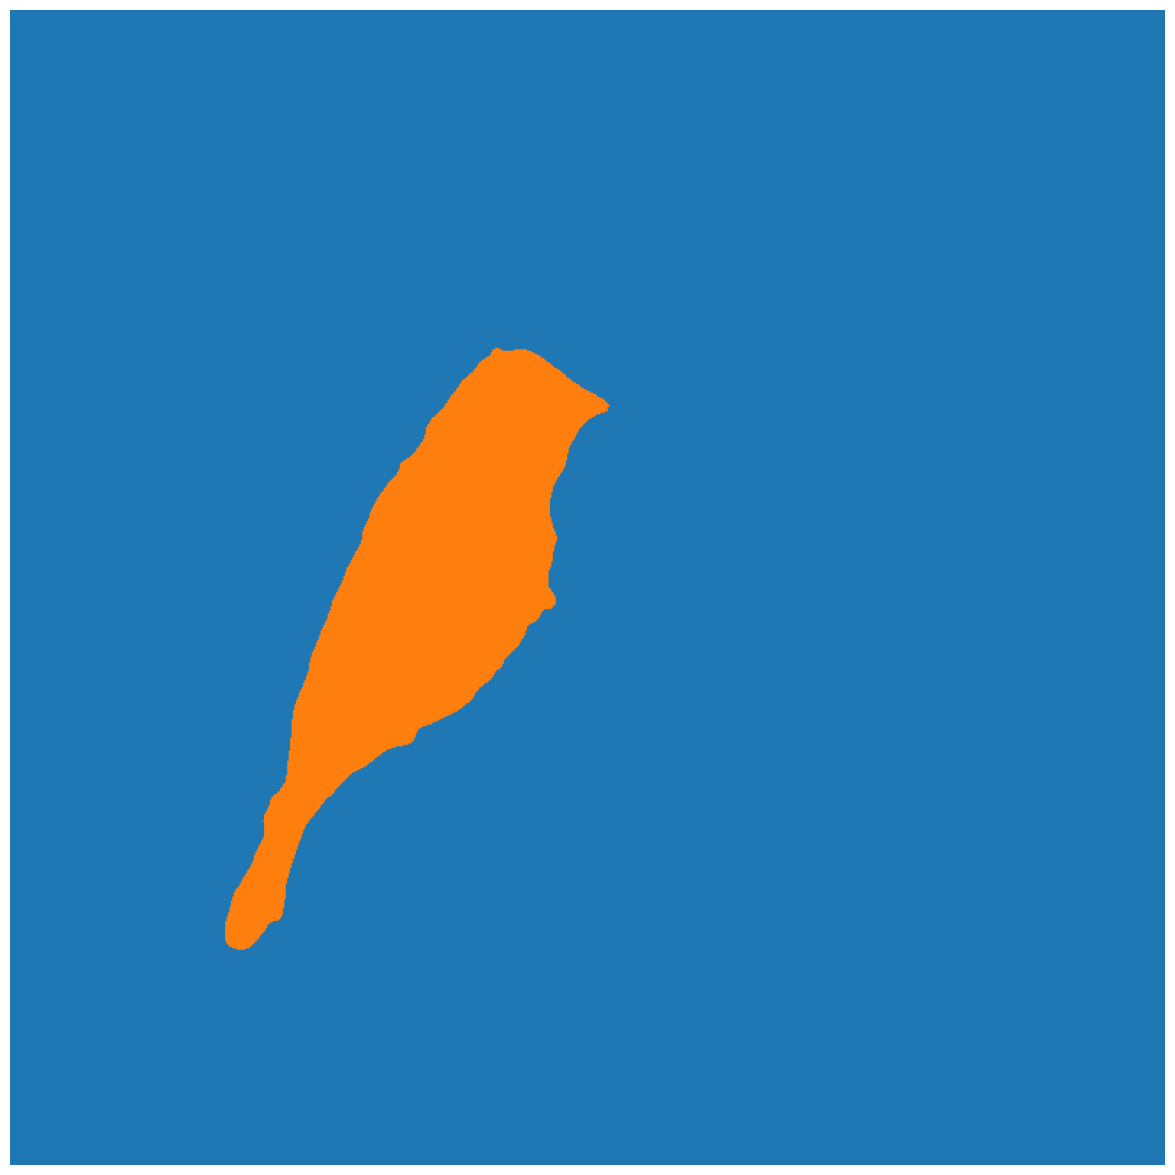

In [26]:
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

import itertools
import seaborn as sns

palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
    panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15, 15))
plt.imshow(panoptic_seg)
plt.axis("off")
plt.show()
